In [1]:
import numpy as np 

import sys
import os

import sys
import os
#sys.path.insert(0, os.path.abspath(".."))
#os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

import jax
import jax.numpy as jnp 

import matplotlib.pyplot as plt

from kltpicker_3d.alt_least_squares import alternating_least_squares_solver
from kltpicker_3d.tests.exp_spectrum import *
from kltpicker_3d.tests.gaussian_spectrum import * 
from kltpicker_3d.utils import * 


plt.style.use('ggplot')

## Pre-whitening

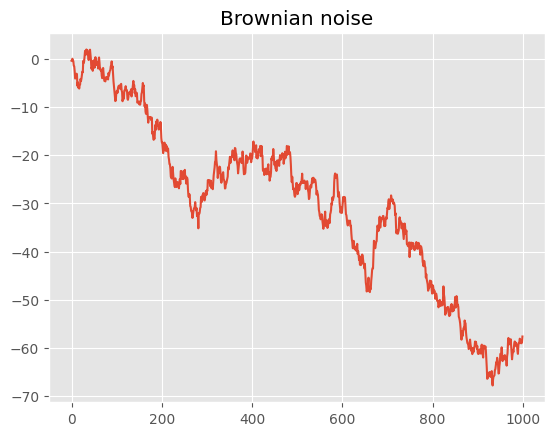

In [3]:
N = 1000

white_noise = np.random.normal(0,1,size=N)
brownian = np.cumsum(white_noise)
plt.plot(brownian)
plt.title("Brownian noise");

/tmp/ipykernel_3777287/2205875160.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.plot(freqs, 1/freqs**2, label="Theoretical PSD")


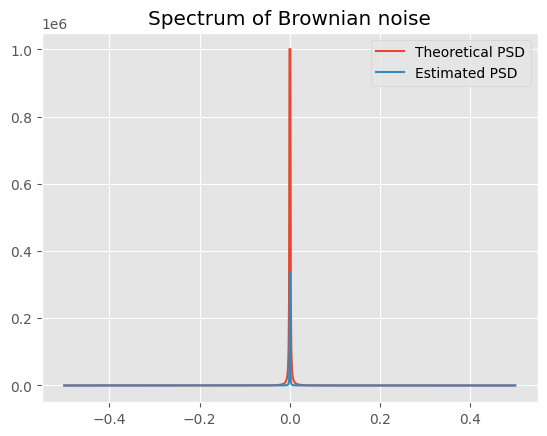

In [4]:
K = 1000
white_noise = np.random.normal(0,1,size=(K,N))
brownian_noises = np.cumsum(white_noise,axis=1)

spectrums= np.abs(np.fft.fftshift(np.fft.fft(brownian_noises, axis=1),axes=1))**2 / N 
psd = np.mean(spectrums,axis=0)
freqs = np.fft.fftshift(np.fft.fftfreq(N))
plt.title("Spectrum of Brownian noise")
plt.plot(freqs, 1/freqs**2, label="Theoretical PSD")
plt.plot(freqs,psd, label="Estimated PSD")
plt.legend();

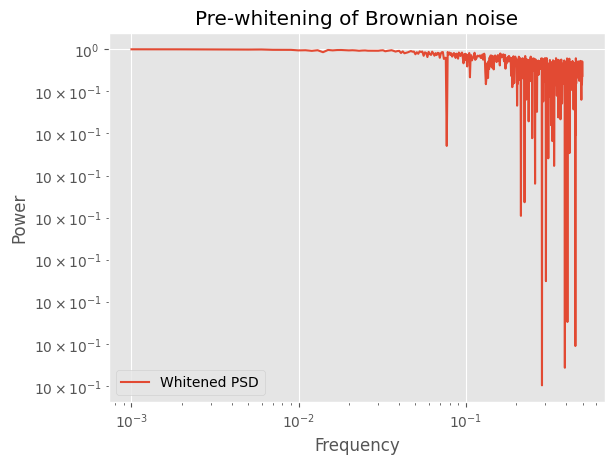

In [5]:
white = np.random.randn(N)
brownian = np.cumsum(white)

freqs = np.fft.fftfreq(N)
brownian_fft = np.fft.fft(brownian)
psd = np.abs(brownian_fft)**2


whitening_filter = 1 / (np.sqrt(psd) + 1e-12)

whitened_fft = brownian_fft * whitening_filter
whitened_psd = np.abs(whitened_fft)**2

#plt.loglog(freqs[1:N//2], psd[1:N//2],label="Original PSD")
plt.loglog(freqs[1:N//2], whitened_psd[1:N//2], label="Whitened PSD")
plt.title("Pre-whitening of Brownian noise")
plt.xlabel('Frequency')
plt.ylabel("Power")
plt.legend();

In [ ]:
n = 20
x = 0.5 + np.arange(n)*0.5 
y = x ** 2
xq = 1 + np.arange(10)

scale = (x[1] - x[0]) * n / 2 
xs = (x / scale) * np.pi / 2 
xi = (xq / scale) * np.pi / 2

delta = xi[:, None] - xs[None, :]
M = np.sin(n*delta) / (n *np.sin(delta))
M[np.isclose(delta,0)] = 1

In [2]:
def trigonometric_interpolation(x,y,z):
    """ 
    Vectorized trigonometric interpolation for equidistance points. 

    args:
        - x: equidistance sample points 
        - y: function values at sampled points
        - z: evaluation points for interpolation
    """
    n = x.shape[0]
    
    scale = (x[1] - x[0]) * n / 2 
    x_scaled = (x / scale) * np.pi / 2 
    z_scaled = (z / scale) * np.pi / 2

    delta = z_scaled[:, None] - x_scaled[None, :]

    if n % 2 == 0:
        M = np.sin(n*delta) / (n *np.sin(delta))
    else:
        M = np.sin(n*delta)/ (n*np.tan(delta))
    M[np.isclose(delta,0)] = 1

    p = M @ y 
    return p

/tmp/ipykernel_512989/3790366184.py:19: RuntimeWarning: invalid value encountered in divide
  M = np.sin(n*delta) / (n *np.sin(delta))


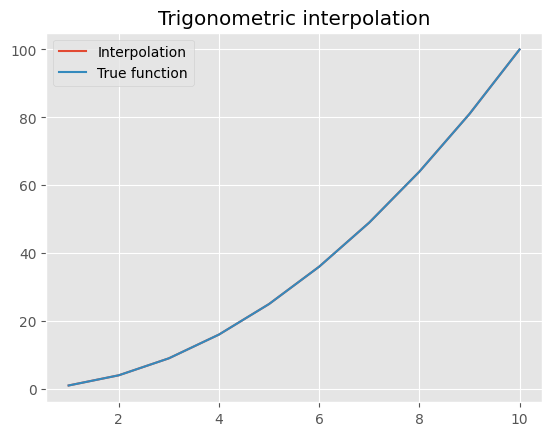

In [3]:
n = 20
x = 0.5 + np.arange(n)*0.5 
y = x ** 2
xq = 1 + np.arange(10)

p = trigonometric_interpolation(x,y, xq)
plt.plot(xq,p,label='Interpolation')
plt.plot(xq, xq ** 2, label='True function')
plt.title("Trigonometric interpolation")
plt.legend();

## Creating grid for uniform radial sampling points

The factorization of the RPSD eventually give us radial signals, that is 1-dimensional signals of both the particle spectrum and the noise spectrum. 
As we need later to interpolate it we need to have the signal at uniform sampling if we wish to use Trigonometric Interpolation.

However the sampling points generated by the behavior of the indices: $\sqrt{i^2 + j^2 + k^2}$. So it's strict than that. Instead one can generate a 3-D ACF and populate it radially to compute the 3D FFT. 
Than one can do radial average over uniform radial points and use bins to average. 

Q: Is this really necessary? What if we don't use uniform sampling. We know that points at which the 1-dimensional particle spectrum was sampled at; that is the distances generated by the indices. 
Can we use some general interpolation mechanism? Can we use any assumption on the RPSD that will allow us to better interpolate? I've seen that it's usally either Gaussian or exponential.

In [ ]:
K = 10
M = 10**2 # number of patches
L = 32
N = 2*L -1 

# Uniform sample points in [-1,1]
grid = 2/(N-1)*np.arange(N) - 1
X,Y = np.meshgrid(grid,grid)

r = (X**2 + Y** 2 ) ** 0.5 
spacing = 1 /(L-1)

# Uniform spacings for creating equdisant radial sampling points
r_bins = np.linspace(-spacing/2, spacing/2 + 1, L+1 )

# Approximated uniform sampling points by averaging bins end-points
uniform_points = (r_bins[0:-1] + r_bins[1:])/2 

bins = []
for j in range(L - 1):
    bins.append(np.where(np.logical_and(r >= r_bins[j], 
                                        r < r_bins[j + 1])))
    
bins.append(np.where(np.logical_and(r >= r_bins[L - 1], 
                                    r <= 1)))

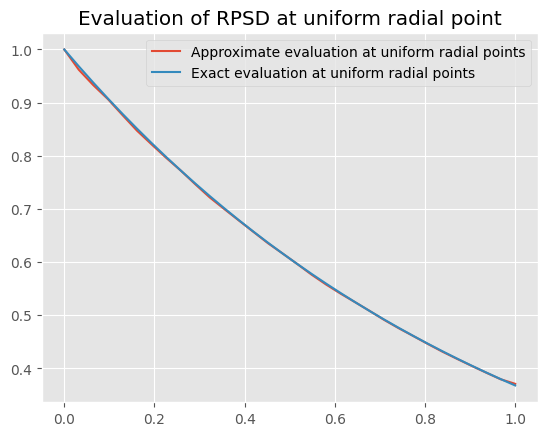

In [158]:
def radial_average(X, bins, n):
    S = np.zeros(n)
    for j in range(n):
        bin_len = bins[j][0].size
        S[j] += np.sum(X[bins[j]])/bin_len
    return S

grid = np.arange(-(L-1),L)
i,j = np.meshgrid(grid,grid)
r1 = np.sqrt(i**2 + j**2) / (L-1)
spectrum = np.exp(-r1)


s = radial_average(spectrum, bins, L)

true_spec = np.exp(-uniform_points)


plt.plot(uniform_points,s, label='Approximate evaluation at uniform radial points')
plt.plot(uniform_points,true_spec,label='Exact evaluation at uniform radial points')
plt.title("Evaluation of RPSD at uniform radial point")
plt.legend();

In [149]:
# This is a test to validate that the values are indeed bounded correctly in their magnitude
tt = [ np.logical_and(r1[bins[j]] <= r_bins[j+1], r1[bins[j]] >= r_bins[j]) for j in range(L-1)]
np.mean([np.mean(tt[i]) for i in range(L-1)])

np.float64(1.0)

Q: It can be seen that this is correct only when the magnitude is normalized by L-1. However when we are given an existing 3-d data we are not in charge of generating it in this normalized way. 
Is it okay because it only shift the function arguments? Like it only scales it.

## Experiment through full-pipeline up to extracting clean particle RPSD

In [2]:
from kltpicker_3d.tests.gaussian_spectrum import * 
from kltpicker_3d.spectral_estimation import estimate_isotropic_powerspectrum_tensor

K = 100
M = 10**2 # number of patches
L = 32
N = 2*L -1 

samples, S, spectrum = generate_gaussian_spectrum(L, K)

/scratch/home/moshemaymon/3D_KLT/kltpicker_3d/tests/gaussian_spectrum.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k,...] = sample[:N,:N,:N]
/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/jax/_src/array.py:425: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype, **kwds)


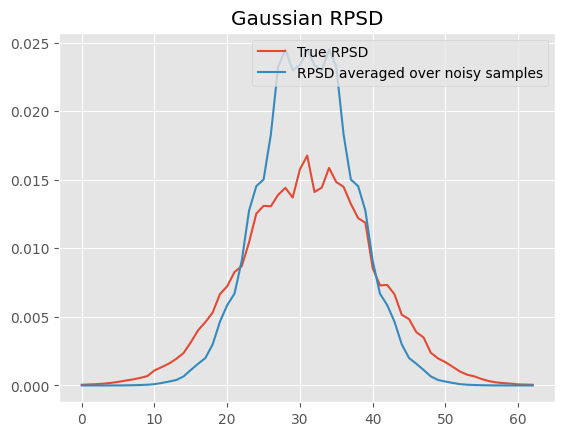

In [ ]:
plt.title("Gaussian RPSD")
plt.plot(spectrum[L,L,:], label='True RPSD')
plt.plot(S[L,L,:], label='RPSD averaged over noisy samples')
plt.legend();

In [4]:
max_d = int(np.floor(L/2))

vectorized_spectral_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor, in_axes=(0,None))
psds = vectorized_spectral_estimation(samples, max_d)

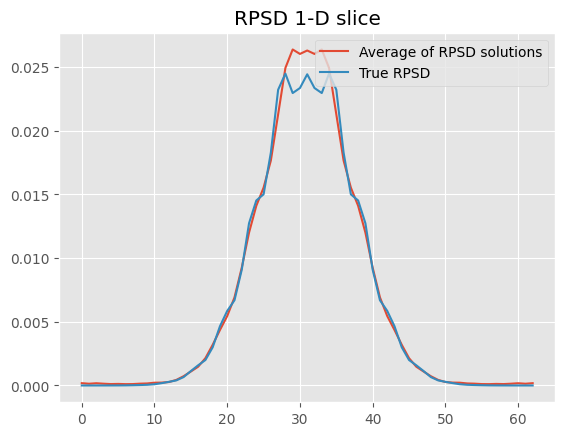

In [5]:
# TODO: Note that there constants in energy-preservations might be
# off.
avg_psd = np.mean(psds,axis=0)
avg_psd /= np.linalg.norm(avg_psd)
plt.title("RPSD 1-D slice")
plt.plot(avg_psd[L,L,:], label='Average of RPSD solutions');
plt.plot(S[L,L,:], label='True RPSD')
plt.legend();

In [6]:
# Uniform sample points in [-1,1]
grid = 2/(N-1)*np.arange(N) - 1
i,j,k= np.meshgrid(grid,grid, grid)

r = (i**2 + j** 2 + k**2) ** 0.5 
spacing = 1 /(L-1)

# Uniform spacings for creating equdisant radial sampling points
r_bins = np.linspace(-spacing/2, spacing/2 + 1, L+1 )

# Approximated uniform sampling points by averaging bins end-points
uniform_points = (r_bins[0:-1] + r_bins[1:])/2 

bins = []
for j in range(L - 1):
    bins.append(np.where(np.logical_and(r >= r_bins[j], 
                                        r < r_bins[j + 1])))
    
bins.append(np.where(np.logical_and(r >= r_bins[L - 1], 
                                    r <= 1)))

def radial_average(X, bins, n):
    S = np.zeros(n)
    for j in range(n):
        bin_len = bins[j][0].size
        S[j] += np.sum(X[bins[j]])/bin_len
    return S

# TODO: Re-write radial average to be vmap-able
rblocks = np.zeros((K,L))
for k in range(K):
    rblocks[k] = radial_average(psds[k],bins,L)

In [8]:
factorization = alternating_least_squares_solver(rblocks,200,1e-2)
particle_psd = factorization.gamma
noise_psd = factorization.v

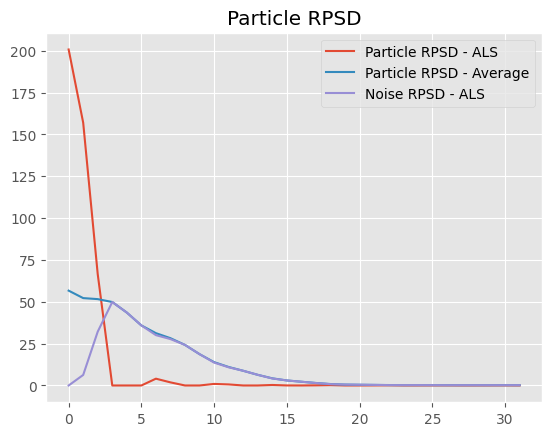

In [9]:
plt.plot(particle_psd, label='Particle RPSD - ALS')
plt.plot(np.mean(rblocks,axis=0),label='Particle RPSD - Average')
plt.plot(noise_psd, label='Noise RPSD - ALS')
plt.title("Particle RPSD")
plt.legend();

Interesting behavior happens here. It detects the noise RPSD to be the same as the average. 

Q: 

- Is it even correct to use this here as there's no alpha presence in the simuation? Although technically they all 1.
- Is it cause I didn't remvoe the mean from the signal?

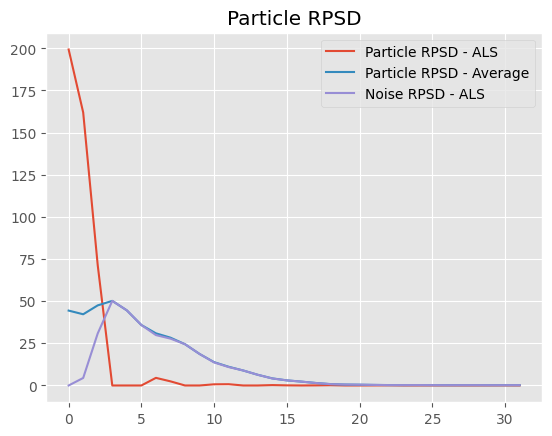

In [19]:
fixed_samples = samples - np.mean(samples,axis=(1,2,3)).reshape(-1,1,1,1)
psds = vectorized_spectral_estimation(fixed_samples, max_d)

# TODO: Re-write radial average to be vmap-able
rblocks = np.zeros((K,L))
for k in range(K):
    rblocks[k] = radial_average(psds[k],bins,L)


factorization = alternating_least_squares_solver(rblocks,200,1e-2)
particle_psd = factorization.gamma
noise_psd = factorization.v


plt.plot(particle_psd, label='Particle RPSD - ALS')
plt.plot(np.mean(rblocks,axis=0),label='Particle RPSD - Average')
plt.plot(noise_psd, label='Noise RPSD - ALS')
plt.title("Particle RPSD")
plt.legend();

## Full pipeline experiment (up to constants)

In [41]:
K = 100
M = 10**2 # number of patches
L = 32
N = 2*L -1 

samples, S, spectrum = generate_gaussian_spectrum(L, K)

/scratch/home/moshemaymon/3D_KLT/kltpicker_3d/tests/gaussian_spectrum.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k,...] = sample[:N,:N,:N]


Text(0.5, 1.0, '1D Power Spectrum slice')

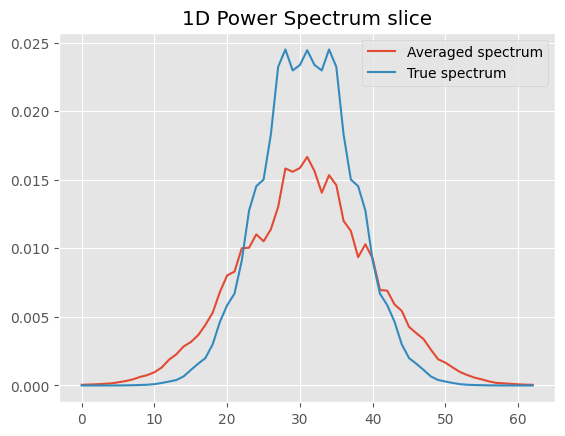

In [42]:
plt.plot(spectrum[L,L,:],label="Averaged spectrum")
plt.plot(S[L,L,:],label="True spectrum")
plt.legend()
plt.title("1D Power Spectrum slice")

In [43]:
max_d = int(np.floor(L/3))
vectorized_spectral_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor, in_axes=(0,None))

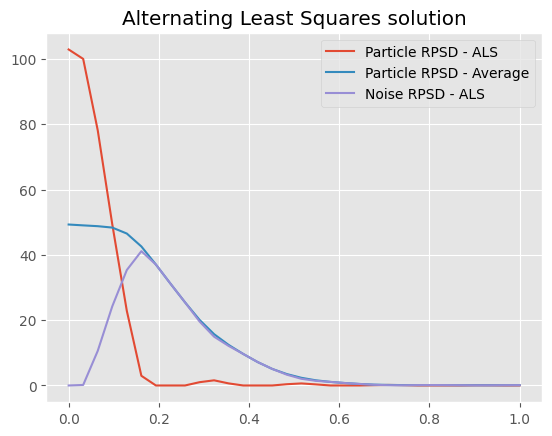

In [44]:
from kltpicker_3d.utils import generate_uniform_radial_sampling_points


def radial_average(X, bins, n):
    S = np.zeros(n)
    for j in range(n):
        bin_len = bins[j][0].size
        S[j] += np.sum(X[bins[j]])/bin_len
    return S

uniform_points, bins = generate_uniform_radial_sampling_points(L)


fsamples = samples - np.mean(samples,axis=(1,2,3)).reshape(-1,1,1,1)
psds = vectorized_spectral_estimation(fsamples, max_d)
# The psds here are centerized 


rblocks = np.zeros((K,L))
for k in range(K):
    rblocks[k] = radial_average(psds[k],bins,L)

# After this we have that the data is centerized at 0, that is
# the DC component is at 0
factorization = alternating_least_squares_solver(rblocks,200,1e-2)
particle_psd = factorization.gamma
noise_psd = factorization.v


plt.plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
plt.plot(uniform_points,np.mean(rblocks,axis=0),label='Particle RPSD - Average')
plt.plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
plt.title("Alternating Least Squares solution")
plt.legend();

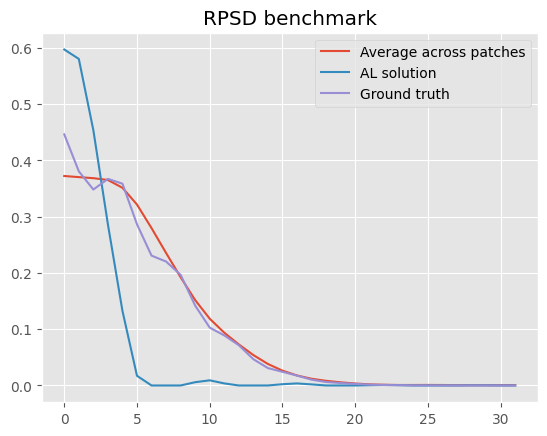

In [ ]:
sigma = 1 
w = 2*5*sigma 
w0 = w / N

grid = np.arange(-(L-1),L)
i,j,k  = np.meshgrid(grid,grid,grid) 
omega_x, omega_y, omega_z = i*w0, j*w0, k*w0
omega_r = np.sqrt(omega_x ** 2 + omega_y ** 2 + omega_z ** 2)
H = (1/np.sqrt(2*np.pi * sigma ** 2)) * np.exp(- omega_r ** 2 / (2*sigma ** 2)) * (1 + 0.1 * np.cos(10*omega_r))

H /= np.linalg.norm(H)
true_rpsd = radial_average(H,bins,L)
true_rpsd /= np.linalg.norm(true_rpsd)
particle_psd /= np.linalg.norm(particle_psd)
avg_psd = np.mean(rblocks,axis=(0))
avg_psd /= np.linalg.norm(avg_psd)
plt.title("RPSD benchmark")
plt.plot(avg_psd, label='Average across patches')
plt.plot(particle_psd,label='AL solution')
plt.plot(true_rpsd, label='Ground truth')
plt.legend();

We observe that the calculation itself so far is indeed correct as the average of RPSDs calculated do converge to the true RPSD evaluated at the points.
However the ALS is off. It seems to be due to wrong modeling in the dataset creation.

In [8]:
from kltpicker_3d.utils import trigonometric_interpolation

# Creating an interpolation matrix containg the noise psd.
grid = np.arange(-(L-1), L) * np.pi / L
i,j,k = np.meshgrid(grid,grid,grid)
r_matrix = np.sqrt(i**2 + j**2 + k**2)
magnitudes, idx = np.unique(r_matrix, return_inverse=True)
nodes = magnitudes[magnitudes < uniform_points[-1]*np.pi]

interpolated_noise_psd = trigonometric_interpolation(uniform_points*np.pi, noise_psd, nodes)
noise_psd_mat = np.pad(interpolated_noise_psd, 
                      (0,
                       magnitudes.size - interpolated_noise_psd.size),
                      'constant',
                      constant_values=interpolated_noise_psd[-1])
noise_psd_mat = np.reshape(noise_psd_mat[idx], [grid.size, grid.size, grid.size])

/scratch/home/moshemaymon/3D_KLT/kltpicker_3d/utils.py:101: RuntimeWarning: invalid value encountered in divide
  M = np.sin(n*delta) / (n *np.sin(delta))


In [9]:
def prewhiten_patch(patch, noise_psd):
    """ Pre-whitening a given patch with side of length L 
        using a noise_psd with side of length 2L-1.
    """
    L = patch.shape[0]
    midpoint = int(np.ceil(L - 0.5))

    start = midpoint - L//2
    end = midpoint + L//2 

    filter = jnp.sqrt(noise_psd)
    filter /= jnp.linalg.norm(filter)
    
    #Symmetrize the PSD across each axis
    filter = (filter + jnp.flip(filter,axis=0))/2
    filter = (filter + jnp.flip(filter,axis=1))/2
    filter = (filter + jnp.flip(filter,axis=2))/2

    delta = jnp.finfo(patch.dtype).eps
    mask = filter > 100 * delta
    filter = jnp.where(mask, 1 / filter,0)

    padded = jnp.zeros_like(noise_psd)
    padded = padded.at[start:end, start:end, start:end].set(patch)

    fp = jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(padded)))
    fp *= filter 
    pp2 = jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(fp)))
    p2 = pp2[start:end,start:end,start:end].real 
    return p2 

vectorized_prewhiten = jax.vmap(prewhiten_patch, in_axes=(0,None))
whitened_patches = vectorized_prewhiten(samples,noise_psd_mat)

In [10]:
clean_samples = whitened_patches - np.mean(whitened_patches)
clean_samples /= np.linalg.norm(clean_samples)

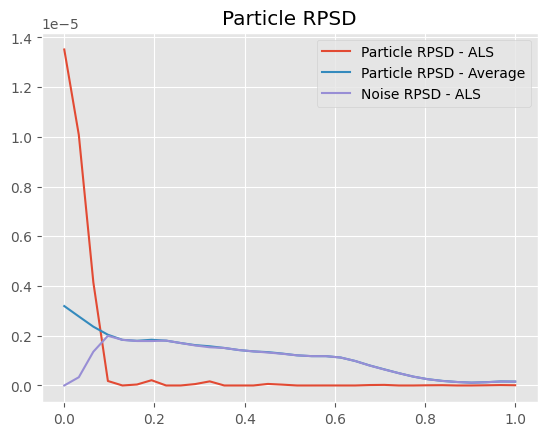

In [11]:
fsamples = clean_samples - np.mean(clean_samples,axis=(1,2,3)).reshape(-1,1,1,1)
psds = vectorized_spectral_estimation(fsamples, max_d)

# TODO: Re-write radial average to be vmap-able
rblocks = np.zeros((K,L))
for k in range(K):
    rblocks[k] = radial_average(psds[k],bins,L)


factorization = alternating_least_squares_solver(rblocks,400,1e-2)
particle_psd = factorization.gamma
noise_psd = factorization.v


plt.plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
plt.plot(uniform_points,np.mean(rblocks,axis=0),label='Particle RPSD - Average')
plt.plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
plt.title("Particle RPSD")
plt.legend();

## Different modeling of data

In [82]:
from kltpicker_3d.utils import generate_uniform_radial_sampling_points


def radial_average(X, bins, n):
    S = np.zeros(n)
    for j in range(n):
        bin_len = bins[j][0].size
        S[j] += np.sum(X[bins[j]])/bin_len
    return S

uniform_points, bins = generate_uniform_radial_sampling_points(N)

vectorized_spectral_estimation = jax.vmap(estimate_isotropic_powerspectrum_tensor, in_axes=(0,None))

In [106]:
K = 200
N = 32
M = 2*N - 1 
max_d = int(np.floor(N/3))

sigma = 1 
w = 2*5*sigma 
w0 = w / M

grid = np.arange(-(N-1),N) 
i,j,k  = np.meshgrid(grid,grid,grid) 
omega_x, omega_y, omega_z = i*w0, j*w0, k*w0
omega_r = np.sqrt(omega_x ** 2 + omega_y ** 2 + omega_z ** 2)
H = (1/np.sqrt(2*np.pi * sigma ** 2)) * np.exp(- omega_r ** 2 / (2*sigma ** 2)) * (1 + 0.1 * np.cos(10*omega_r))
C = M ** 3 / H.sum()
normalized_H = np.fft.ifftshift(np.sqrt(H * C))

window = np.bartlett(M)
samples = np.zeros((K,N,N,N))
spectrum = np.zeros((K,M,M,M))
alphas = np.random.beta(2,5,size=(K)) 
# Asymetric distriution with 0-skewness
std = 1
for k in range(K):
    noise = np.random.normal(size=(M,M,M)) 
    additive_noise = np.random.normal(scale=std,size=(M,M,M))
    sample = np.fft.ifftn(normalized_H*np.fft.fftn(noise))
    sample = alphas[k]*sample + additive_noise
    samples[k] = sample[:N,:N,:N]
    spectrum[k] = cfftn(sample * window)

spectrum = np.mean(np.abs(spectrum),axis=0)
spectrum /= np.linalg.norm(spectrum) 

samples = samples.real 
S = H / np.linalg.norm(H)

/tmp/ipykernel_212635/2800602756.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  samples[k] = sample[:N,:N,:N]
/scratch/home/moshemaymon/.conda/envs/moshiko/lib/python3.10/site-packages/jax/_src/array.py:425: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype, **kwds)


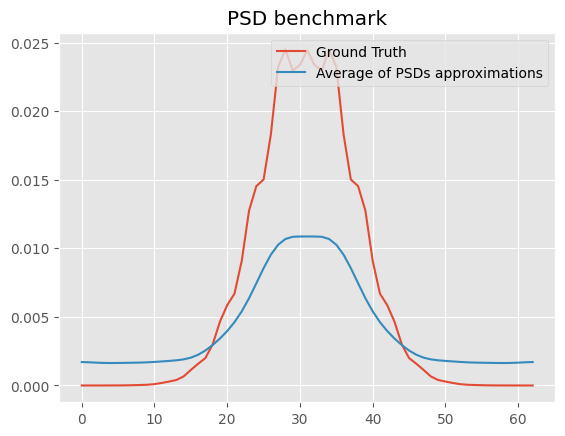

In [107]:
fsamples = samples - np.mean(samples,axis=(1,2,3)).reshape(-1,1,1,1)
psds = vectorized_spectral_estimation(fsamples, max_d)

plt.title("PSD benchmark")
psd_avg = np.mean(psds,axis=0)
psd_avg /= np.linalg.norm(psd_avg)
plt.plot(S[N,N,:],label='Ground Truth')
plt.plot(psd_avg[N,N,:], label='Average of PSDs approximations')
plt.legend();

/tmp/ipykernel_212635/2640844196.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


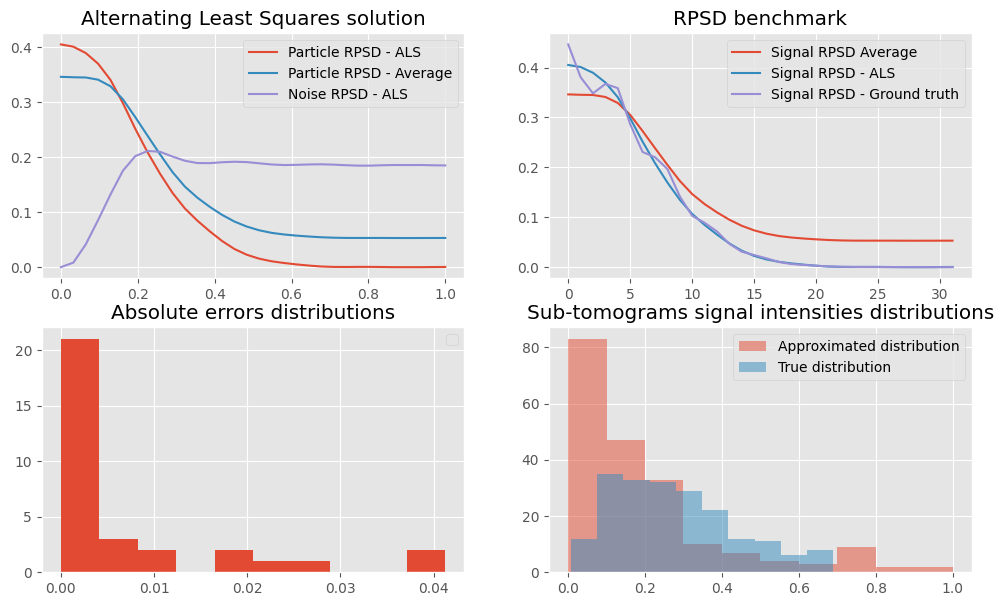

In [108]:
rblocks = np.array([radial_average(psds[k], bins, N) for k in range(K)])

# After this we have that the data is centerized at 0, that is
# the DC component is at 0
factorization = alternating_least_squares_solver(rblocks,500,1e-4)
particle_psd = factorization.gamma
noise_psd = factorization.v

noise_psd /= np.linalg.norm(noise_psd)
particle_psd /= np.linalg.norm(particle_psd)

avg_psd = np.mean(rblocks,axis=(0))
avg_psd /= np.linalg.norm(avg_psd)

fig, ax = plt.subplots(2,2, figsize=(12,7))

extracted_alphas = factorization.alpha

H /= np.linalg.norm(H)

true_rpsd = radial_average(H,bins,N)
true_rpsd /= np.linalg.norm(true_rpsd)

ax[0,0].plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
ax[0,0].plot(uniform_points,avg_psd,label='Particle RPSD - Average')
ax[0,0].plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
ax[0,0].set_title("Alternating Least Squares solution")
ax[0,0].legend()


ax[0,1].plot(avg_psd, label='Signal RPSD Average')
ax[0,1].plot(particle_psd,label='Signal RPSD - ALS')
ax[0,1].plot(true_rpsd, label='Signal RPSD - Ground truth')
ax[0,1].legend()
ax[0,1].set_title("RPSD benchmark")
ax[0,1].legend()

ax[1,0].set_title("Absolute errors distributions")
ax[1,0].hist(np.abs(true_rpsd - particle_psd));
ax[1,0].legend()

ax[1,1].set_title("Sub-tomograms signal intensities distributions")
ax[1,1].hist(extracted_alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].hist(alphas,alpha=0.5,label='True distribution')
ax[1,1].legend();

After multiple experiments and tests the algorithm previously failed to work as I implictly assumed all alphas are 1. 
The algorithm fails to work with such delta-shaped distribution + it's skewed to detect alphas towards 0. (There's thresholding occuring over each iteration bounding alphas between 0 and 1)

In [109]:
from kltpicker_3d.tomogram import factorize_RPSD 

factorization = factorize_RPSD(samples)

/tmp/ipykernel_212635/1251939386.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,0].legend()


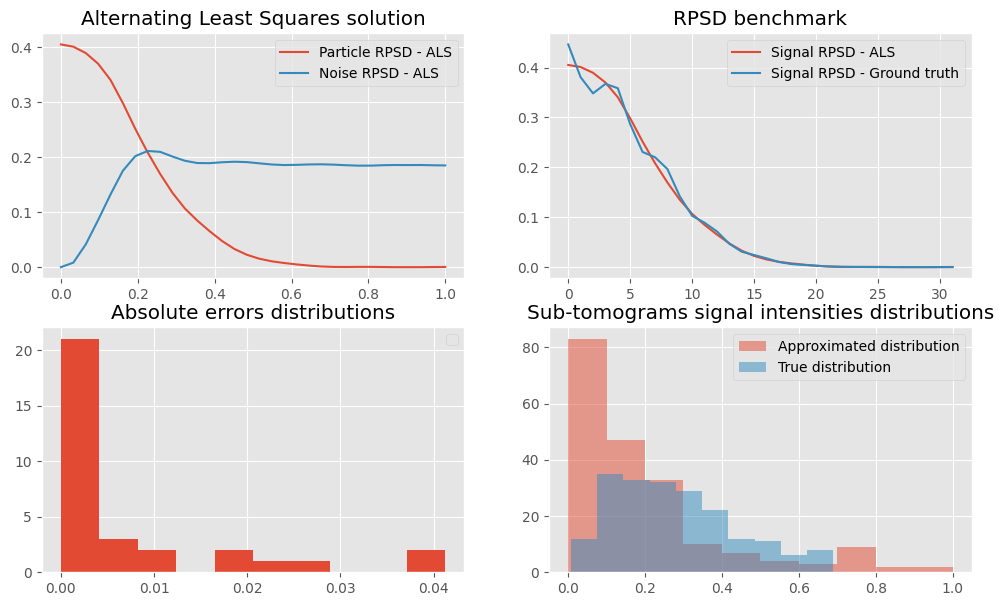

In [110]:
particle_psd = factorization.gamma
noise_psd = factorization.v

noise_psd /= np.linalg.norm(noise_psd)
particle_psd /= np.linalg.norm(particle_psd)


fig, ax = plt.subplots(2,2, figsize=(12,7))

extracted_alphas = factorization.alpha

H /= np.linalg.norm(H)

true_rpsd = radial_average(H,bins,N)
true_rpsd /= np.linalg.norm(true_rpsd)

ax[0,0].plot(uniform_points,particle_psd, label='Particle RPSD - ALS')
ax[0,0].plot(uniform_points,noise_psd, label='Noise RPSD - ALS')
ax[0,0].set_title("Alternating Least Squares solution")
ax[0,0].legend()


ax[0,1].plot(particle_psd,label='Signal RPSD - ALS')
ax[0,1].plot(true_rpsd, label='Signal RPSD - Ground truth')
ax[0,1].legend()
ax[0,1].set_title("RPSD benchmark")
ax[0,1].legend()

ax[1,0].set_title("Absolute errors distributions")
ax[1,0].hist(np.abs(true_rpsd - particle_psd));
ax[1,0].legend()

ax[1,1].set_title("Sub-tomograms signal intensities distributions")
ax[1,1].hist(extracted_alphas,alpha=0.5, label='Approximated distribution')
ax[1,1].hist(alphas,alpha=0.5,label='True distribution')
ax[1,1].legend();

## Test prewhiten on specific sample

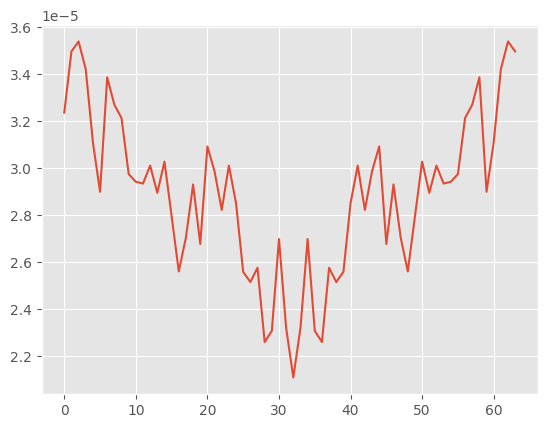

In [203]:
noise = np.random.normal(scale=0.1,size=(300,64,64,64)).astype(np.float32)
freq_grid = [np.fft.fftfreq(n) for n in (64,64,64)]
kx,ky,kz = np.meshgrid(*freq_grid)
k_mag = np.sqrt(kx**2 + ky**2 + kz**2)

k_mag[0,0,0] = 1.0

filter_ = 1 / (k_mag ** 2)
filter_ = np.sqrt(filter_)
colored_noise = np.fft.ifftn(np.fft.fftn(noise,axes=(1,2,3))*filter_[None,...]).real

spectrum = np.mean(np.abs(np.fft.fftn(colored_noise,axes=(1,2,3)))**2,axis=0) / k_mag.size
plt.plot(spectrum[32,32,:])

In [258]:
def prewhiten_patch(patch, noise_psd):
    L,_,_ = patch.shape
    M,_,_ = noise_psd.shape
    midpoint = M//2

    start = midpoint - L//2
    end = midpoint + L//2 

    filter = jnp.sqrt(noise_psd)
    filter /= jnp.linalg.norm(filter)
    
    #Symmetrize the PSD across each axis
    filter = (filter + jnp.flip(filter,axis=0))/2
    filter = (filter + jnp.flip(filter,axis=1))/2
    filter = (filter + jnp.flip(filter,axis=2))/2

    mask = filter > 1e-14
    filter = jnp.where(mask, 1 / filter,0)

    padded = jnp.zeros_like(noise_psd)
    padded = padded.at[start:end, start:end, start:end].set(patch)

    fp = jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(padded)))
    fp *= filter 
    pp2 = jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(fp)))
    p2 = pp2[start:end,start:end,start:end].real 
    return p2 

vect_prewhiten = jax.vmap(prewhiten_patch, in_axes=(0,None))
white = vect_prewhiten(colored_noise, filter_**2)

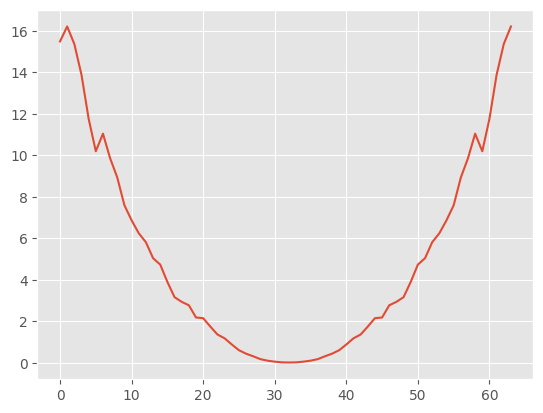

In [259]:
white_spectrum = np.mean(np.abs(np.fft.fftn(white,axes=(1,2,3)))**2,axis=0) / k_mag.size
plt.plot(white_spectrum[32,32,:])

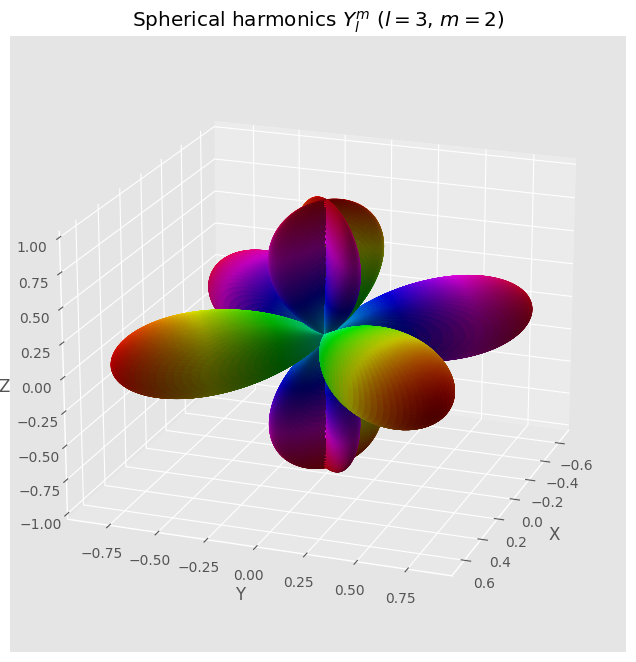

In [ ]:
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import sph_harm

#primary source:
#https://physicslabs.augustana.edu/index.php/courses/foundational-physics-iii-phys-213/plotting-spherical-harmonics-in-3d/
 
# resolution
N = 256 

# Create meshgrid of polar, azimuthal angle points to plot
theta = np.linspace(0, np.pi, N)
phi = np.linspace(0, 2*np.pi, N)
theta, phi = np.meshgrid(theta, phi)

#This is the part that I really modified.
#The rest is very similar to the primary source.
l = 3
m = 2
Y = sph_harm(m, l, theta, phi)
Y_real = np.real(Y)

# Make some adjustments for nice plots
Ymax, Ymin = Y_real.max(), Y_real.min()
if (Ymax != Ymin):
# normalize the values to [1, -1]
    Y_real = 2 * (Y_real - Ymin)/(Ymax - Ymin) - 1
# Use the absolute value of Y(l,m) as the radius
    radii = np.abs(Y_real)
# put the colors in the range [1, 0]
    Ycolors = 0.5 * (Y_real + 1)
else:
# can't normalize b/c Y(0,0) is single-valued
    radii = np.ones(Y_real.shape)
    Ycolors = np.ones(Y_real.shape)
 
# Compute Cartesian coordinates of the surface
x = radii * np.sin(theta) * np.cos(phi)
y = radii * np.sin(theta) * np.sin(phi)
z = radii * np.cos(theta)
 
# Do the actual plotting
# negative values will be blue, positive red
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, 
                facecolors=cm.hsv(Ycolors))
ax.view_init(elev=20, azim=20, roll=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(rf"Spherical harmonics $Y_l^m$ ($l={l}$, $m={m}$)")
plt.show()